In [11]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import configparser
import os, copy, random
from medpy.filter.smoothing import anisotropic_diffusion

In [5]:
os.path.isdir("/home/jongmunchoi/code/FB_synthesizer/FB_Xray2/")

False

In [10]:
config = configparser.ConfigParser()
config.read('config.ini')

base_folder = config['DEFAULT']['base_folder']
annotation_folder = config['DEFAULT']['annotation_folder']
annotation_folder_fullurl = os.path.join(base_folder, annotation_folder)
if os.path.isdir(annotation_folder_fullurl) == False:
    os.mkdir(f"{annotation_folder_fullurl}")
    os.mkdir(f"{annotation_folder_fullurl}/Annotation")
    os.mkdir(f"{annotation_folder_fullurl}/Masks")
    os.mkdir(f"{annotation_folder_fullurl}/PNGImages")

False

In [12]:
#configure and url setting
config = configparser.ConfigParser()
config.read('config.ini')

base_folder = config['DEFAULT']['base_folder']
xray_folder = config['DEFAULT']['xray_folder']
annotation_folder = config['DEFAULT']['annotation_folder']
annotation_folder_fullurl = os.path.join(base_folder, annotation_folder)
if os.path.isdir(annotation_folder_fullurl) == False:
    os.mkdir(f"{annotation_folder_fullurl}")
    os.mkdir(f"{annotation_folder_fullurl}/Annotation")
    os.mkdir(f"{annotation_folder_fullurl}/Masks")
    os.mkdir(f"{annotation_folder_fullurl}/PNGImages")

xray_folder = os.path.join(base_folder, xray_folder)
source_folder = config['DEFAULT']['source_folder']
source_folder = os.path.join(base_folder, source_folder)


if os.path.isdir(base_folder) == False:
    raise exception("base folder name is wrong. check config.ini file")
if os.path.isdir(xray_folder) == False:
    raise exception("xray folder name is wrong. check config.ini file")
if os.path.isdir(source_folder) == False:
    raise exception("source image folder name is wrong. checkl config.ini file")

urls__xray_file = os.listdir(xray_folder)
urls__source_file = os.listdir(source_folder)

In [13]:
def antialiasing(img):
    img_filtered = anisotropic_diffusion(img)
    return img_filtered

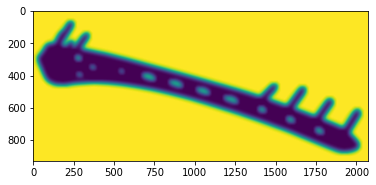

In [51]:
artifact = cv2.imread("/home/jongmunchoi/code/FB_synthesizer/source_img/femur_plate_1.jpg", cv2.IMREAD_GRAYSCALE)
kernel = np.ones((5, 5), np.float32)/25 
artifact_blur = cv2.filter2D(artifact, -1, kernel)
_, artifact_dst = cv2.threshold(artifact_blur, 180, 200, cv2.THRESH_BINARY)
artifact_resize = cv2.resize(artifact_dst,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
#artifact_resize_blur = cv2.filter2D(artifact_resize, -1, kernel)
#artifact_resize_antialiasing = antialiasing(artifact_resize)
kernel_size = 5
kernel2 = np.ones((kernel_size, kernel_size), np.float32)/(kernel_size*kernel_size )
artifact_resize_reblur = cv2.filter2D(artifact_resize, -1, kernel2)
for iter in range(100):
    artifact_resize_reblur = cv2.filter2D(artifact_resize_reblur, -1, kernel2)
cv2.imwrite('FB_Xray2/PNGImages/test5.png', artifact_resize_reblur)
plt.imshow(artifact_resize_reblur)

In [15]:
artifact

array([[253, 253, 253, ..., 255, 255, 255],
       [253, 253, 253, ..., 255, 255, 255],
       [253, 253, 253, ..., 255, 255, 255],
       ...,
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253]], dtype=uint8)

In [3]:
def artifact_inserting(Image_information):
    #basic variable setting
    image_url = Image_information["image_url"]
    artifact_url = Image_information["artifact_url"]
    position = Image_information["position"]
    rotation = Image_information["rotation"]
    opacity = Image_information["opacity"]
    x_ray = Image_information["image"]
    mask_marker = Image_information["mask_marker"]
    mask_layer = Image_information["mask_layer"]
    original_image = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)
    count__artifact_fixel = 0
    count__artifact_valid_fixel = 0
    
    #if Image_information has previous x_ray image and/or mask_layer, use it,
    #if not, use original image and corresponding mask layer.
    if hasattr(x_ray, "__len__") == False:
        x_ray = copy.copy(original_image)
    else:
        x_ray = copy.copy(x_ray)

    if hasattr(mask_layer, "__len__") == False:    
        mask_layer = np.zeros(x_ray.shape)
    
    artifact = cv2.imread(artifact_url, cv2.IMREAD_GRAYSCALE)
    Image_information["mag"] = [random.randrange(5,35)/100,random.randrange(5,35)/100]
    mag = Image_information["mag"]
    
    #adjust image size and foriegn body
    adjust_size = original_image.shape[1]/artifact.shape[1]/5
    #print(adjust_size)
    if adjust_size > 1.9:
        mag = [mag[0]*adjust_size, mag[1]*adjust_size]

    #blurring artifact
    kernel = np.ones((5, 5), np.float32)/25 
    artifact_blur = cv2.filter2D(artifact, -1, kernel)
    #artifact_to_binary
    _, artifact_dst = cv2.threshold(artifact_blur, 180, 200, cv2.THRESH_BINARY)
    #artifact_resize
    artifact_resize = cv2.resize(artifact_dst,None,fx=mag[0], fy=mag[1], interpolation = cv2.INTER_CUBIC)
    #artifact_bitwise
    artifact_rev = cv2.bitwise_not(artifact_resize)
    #artifact_rotate
    artifact_rotated = imutils.rotate_bound(artifact_rev, rotation)
    
    #image_insertion
    for idx_y,y in enumerate(artifact_rotated):
        for idx_x,x in enumerate(y):
            #X and Y: position of artifact
            Y = idx_y+position[1]
            X = idx_x+position[0]
            #fixel count: count number of valid fixel insertion
            if artifact_rotated[idx_y][idx_x] > 150:
                count__artifact_fixel += 1
            
            #inserting image should be in x_ray image
            if Y >= x_ray.shape[0] or X >= x_ray.shape[1]:
                continue
            if x < 200:
                continue
            
            new_color = x_ray[Y][X] + int(x*0.7)
            
            #The inserting artifact should be on the original image where is white enough.
            if original_image[Y][X] > 130:
                mask_layer[Y][X] = str(mask_marker)
                #add valid fixel
                count__artifact_valid_fixel += 1
            if new_color > 255:
                new_color = 255
            #change brightness
            x_ray[Y][X] = new_color
    if count__artifact_fixel == 0:
        return False, False
    if count__artifact_valid_fixel/count__artifact_fixel < 0.4:
        return False, False
    return x_ray, mask_layer

In [4]:
def random_information(previous_information):
    img = cv2.imread(previous_information["image_url"], cv2.IMREAD_GRAYSCALE)
    width, height = img.shape
    previous_information["shape"] = img.shape
    min_x = int(width*0.1)
    max_x = int(width*0.85)
    min_y = int(height*0.1)
    max_y = int(height*0.85)
    random_x = random.randrange(min_x, max_x)
    random_y = random.randrange(min_y, max_y)
    previous_information["position"] = [random_x, random_y]
    previous_information["mag"] = [random.randrange(10,35)/100,random.randrange(10,35)/100]
    previous_information["rotation"] = random.randrange(0,360)
    previous_information["opacity"] = random.randrange(80,100)/100
    return previous_information


In [5]:
def get_bbox(information):
    masked_image_bbox = {}
    basic_bbox = {"xmin": float("inf"),
                  "xmax": -1,
                  "ymin": float("inf"),
                  "ymax": -1
                 }
    for idx_y, _ in enumerate(information["masked_image"]):
        for idx_x, _ in enumerate(information["masked_image"][idx_y]):
            mask_tag = int(information["masked_image"][idx_y][idx_x])
            if mask_tag > 0:
                if mask_tag not in masked_image_bbox:
                    masked_image_bbox[mask_tag] = basic_bbox
                masked_image_bbox[mask_tag] = {
                    "xmin": min(idx_x, masked_image_bbox[mask_tag]["xmin"]),
                    "xmax": max(idx_x, masked_image_bbox[mask_tag]["xmax"]),
                    "ymin": min(idx_y, masked_image_bbox[mask_tag]["ymin"]),
                    "ymax": max(idx_y, masked_image_bbox[mask_tag]["ymax"])
                }
    return masked_image_bbox
            

In [6]:
def random_FB_image_generator(information, insert_FB = 1):
    count = 0
    for x in range(insert_FB):
        random_artifact = random.choice(urls__source_file)
        random_artifact = os.path.join(source_folder, random_artifact)
        information["artifact_url"]= random_artifact
        while(True):
            information = random_information(information)
            new_image, new_masked_image = artifact_inserting(information)
            if count > 20:
                information["image"] = []
                return information
            if hasattr(new_image, "__len__"):
                information["image"] = new_image
                information["masked_image"] = new_masked_image
                information["mask_marker"] += 1
                break
            else:
                count += 1
    return information

In [7]:
def make_annotation(information):
    file_name = information["file_name"]
    image_file_name = f"{base_folder}/{annotation_folder}/PNGImages/{file_name}.png"
    mask_file_name = f"{base_folder}/{annotation_folder}/Masks/{file_name}.png"
    width, height = information["shape"]
    bbox = get_bbox(information)
    object_number = len(bbox.keys())
    GT_text = " ".join(['"Foreign Body"'] * object_number)
    basic_format1 = f"""
# Compatible with PASCAL Annotation Version 1.00
Image filename : "{image_file_name}"
Image size (X x Y x C) : {width} x {height} x 3
Database : "FB_Xray Database"
Objects with ground truth : {object_number} [ {GT_text} ]
# Note there may be some objects not included in the ground truth list for they are severe-occluded
# or have very small size.
# Top left pixel co-ordinates : (1, 1)

"""
    basic_format2 = []
    for object_index in bbox:
        xmin = bbox[object_index]["xmin"]
        xmax = bbox[object_index]["xmax"]
        ymin = bbox[object_index]["ymin"]
        ymax = bbox[object_index]["xmax"]
        text = f'''# Details for pedestrian {object_index} ("Foriegn Body")
Original label for object {object_index} "Foriegn Body" : "FB"
Bounding box for object {object_index} "Foriegn Body" (Xmin, Ymin) - (Xmax, Ymax) : ({xmin}, {ymin}) - ({xmax}, {ymax})
Pixel mask for object {object_index} "Foriegn Body" : "{mask_file_name}"
'''
        basic_format2.append(text)
    basic_format2 = "\n".join(basic_format2)
    basic_format1 = basic_format1.replace("[","{").replace("]","}")
    return basic_format1 + basic_format2

In [8]:
def FB_making(n):
    iter = 0
    max_limiter = 0
    while iter < n:
        random_x_ray = random.choice(urls__xray_file)
        random_x_ray = os.path.join(xray_folder, random_x_ray)
        information = {"image": False, "mask_marker": False, "mask_layer": False, "mask_marker": 1, "file_name": str(iter+1)}
        information["image_url"] = random_x_ray
        information = random_FB_image_generator(information)
        if information["image"] == []:
            continue
        else:
            cv2.imwrite(f'FB_Xray/PNGImages/{information["file_name"]}.png', information['image'])
            cv2.imwrite(f'FB_Xray/Masks/{information["file_name"]}.png', information['masked_image'])
            annotation = make_annotation(information)
            with open(f'FB_Xray/Annotation/{information["file_name"]}.txt', "w") as annotation_file:
                annotation_file.write(annotation)
            iter += 1
        max_limiter += 1
        if max_limiter > 99999999999:
            print("error!!! too many pass through")
            break

In [ ]:
FB_making(2000)

/home/jongmunchoi/code/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
